In [50]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from aux_functions import *
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [34]:
single_qubit_error_rate = 0.01
two_qubit_error_rate = 0.005
noise_model_depolarization = depolarizing_noise_model(single_qubit_error_rate, two_qubit_error_rate)

In [51]:
with open('tocken.txt', 'r') as file:
    token_txt = file.read().replace('\n', '')

# service = QiskitRuntimeService(
#     channel='ibm_cloud'.channel_strategy = 'q-ctrl',
#     instance='ibm-q/open/main',
#     token=token_txt
# )
    
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=token_txt
)

In [52]:
backend = service.least_busy(operational=True, simulator=False)
backend

<IBMBackend('ibm_brisbane')>

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


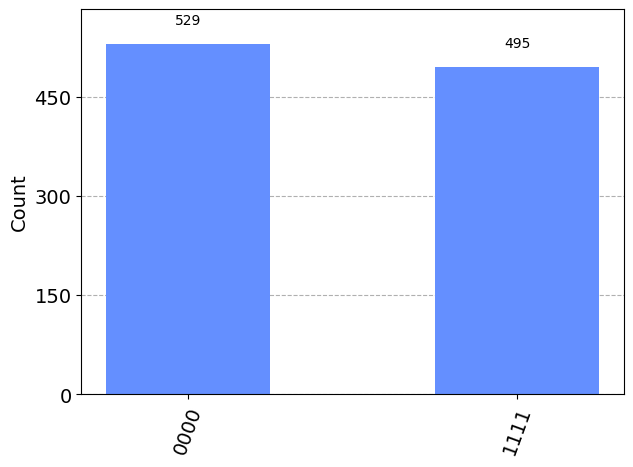

In [53]:
n_qubits = 4
circ1 = generate_GHZ(n_qubits)
print(circ1)
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ1).result()
plot_histogram(result_ideal.get_counts(0))

In [54]:
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session)
    sim_noise = AerSimulator(noise_model=noise_model_depolarization)
    circ_noise = transpile(circ1, sim_noise)
    job = sampler.run([circ_noise])
    result_noise = job.result()[0]
    counts_noise = result_noise.data.cr.get_counts()
    counts_noise_dict = {int(z, 2): counts for z, counts in counts_noise.items()}
    plot_histogram(counts_noise_dict)


IBMInputValueError: 'The instruction rx on qubits (0,) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.'

# another trial

In [16]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from aux_functions import *
 

from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService

with open('tocken.txt', 'r') as file:
    token_txt = file.read().replace('\n', '')
   
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=token_txt
)

backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

In [18]:
n_qubits = 4
circ1 = generate_GHZ(n_qubits)
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circ1]).result()
dist = result[0].data.meas.get_counts()

IBMInputValueError: 'The instruction h on qubits (0,) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.'

In [4]:
noise_model

<NoiseModel on ['ecr', 'x', 'reset', 'id', 'measure', 'sx']>

In [5]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [6]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


In [7]:
# Tensor product two bit-flip and phase-flip errors with
# bit-flip on qubit-0, phase-flip on qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


In [9]:
# Convert to Kraus operator
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([[[ 9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j,  9.74679434e-01+0.j]],

       [[ 0.00000000e+00+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -4.96506831e-17+0.j]]],
      input_dims=(2,), output_dims=(2,))


In [10]:
# Convert to Superoperator
phase_flip_sop = SuperOp(phase_flip)
print(phase_flip_sop)

SuperOp([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0.9+0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0.9+0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 1. +0.j]],
        input_dims=(2,), output_dims=(2,))
